# Deep Neural Network (DNN) with tensorflow

In this notebook I show a DNN using tensorflow for matrix operations but tunned without it and a more pure tensorflow implementation. The first one takes more time of execution. In addition, if you have ever got a **Nan** value in the cost function it migth be because your sigmoid function is causing a 1.0, thus a zero by zero multiplication in the cost function when y==0. Here, I address this issue. See the **Notes** section for detail.

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import time

import tensorflow as tf
tf.__version__

'1.1.0'

In [15]:
dataset_dir='/home/...Dir'
dataset_file='/images.npy'
dataset_location = dataset_dir+'/'+dataset_file
dataset_np = np.load(dataset_location)
print(dataset_np.shape)

Xdata = dataset_np[:,:-1].astype("float32") +0.5
Xdata = Xdata/500.0
Ydata = dataset_np[:,-1:].flatten()#.astype("float32")
targets=list(set(Ydata.tolist()))

Ydata = pd.get_dummies(Ydata)
Ydata = Ydata.values

X_train, X_test, y_train, y_test = train_test_split(Xdata,Ydata)

#X shape here is m by n so we will transpose it : no pure tensorflow
#Xdata = np.transpose(Xdata)
#Ydata = np.transpose(Ydata)

n=Xdata.shape[1]
m=Xdata.shape[0]

t = len(targets)

print("X shape",Xdata.shape,"Y shape",Ydata.shape,"m",m,"n",n,"#Classes",t)
print("Classes:",targets)


(2376, 2501)
X shape (2376, 2500) Y shape (2376, 38) m 2376 n 2500 #Classes 38
Classes: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0]


## Semi manual Deep Neural Network with tensorflow 

In [205]:
X = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

n_x = Xdata.shape[0]
n_y = Ydata.shape[0]

layer_dims = [n_x,2,2,n_y]
nn_size = len(layer_dims)-1

hidden_layer_activation="sigmoid"
layer_activations = []
for i in range(1,nn_size):
    layer_activations.append(hidden_layer_activation)
layer_activations.append("sigmoid")

params = {}
activations = {}

diff_params = {}
 
def initialize_params(n_dims):
    
    tmp_params = {}
    
    rows = tf.placeholder(tf.int32)
    cols = tf.placeholder(tf.int32)
    rand_op = tf.random_normal((rows,cols),mean=0.5, stddev=0.1,seed=1)
    rand_b = tf.zeros((rows,cols))

    with tf.Session() as s:
        s.run(init_op)
        for ls in range(1,len(n_dims)):
            #print(n_dims[ls-1],n_dims[ls])
            
            tmp_params["W"+str(ls)] = s.run(rand_op,feed_dict={rows:n_dims[ls],cols:n_dims[ls-1]})
            tmp_params["b"+str(ls)] = s.run(rand_b,feed_dict={rows:n_dims[ls],cols:1})#mean=0.0, stddev=1.0

    return tmp_params

def linear_activation(iX,iW,ib):
    
    Z = []
    
    W = tf.placeholder(tf.float32)
    b = tf.placeholder(tf.float32)
    X = tf.placeholder(tf.float32)
    z = tf.add(tf.matmul(W,X),b)
    
    with tf.Session() as s:
        Z = s.run(z,feed_dict={X:iX,W:iW,b:ib})
    return Z
def sigmoid_act(iX,iEpsilon=1e-7):
    X = tf.placeholder(tf.float32)
    epsilon=tf.placeholder(tf.float32)
    sigmoid = tf.divide(1.0,tf.add(tf.add(1.0,tf.exp(-X)),epsilon))
    with tf.Session() as s:
        sg = s.run(sigmoid,feed_dict={X:iX,epsilon:iEpsilon})
    return sg

def activate(iZ,act_type="sigmoid"):
    tmp_act = []
    
    z = tf.placeholder(tf.float32)
    sigmoid = tf.nn.sigmoid(z)
    tanh = tf.nn.tanh(z)
    relu = tf.nn.relu(z)
    
    with tf.Session() as s:
        if act_type=="sigmoid":
            tmp_act = sigmoid_act(iZ)
        elif act_type=="tanh":
            tmp_act = s.run(tanh,feed_dict={z:iZ})
        elif act_type=="relu":
            tmp_act = s.run(relu,feed_dict={z:iZ})
    return tmp_act

def forward_propagation(iX,iy,iparams,ilayer_activations,norm=False):
    
    tmp_activations = {"A0":iX}
    
    for i,act in enumerate(ilayer_activations):
        z=linear_activation(tmp_activations["A"+str(i)],iW=iparams["W"+str(i+1)],ib=iparams["b"+str(i+1)])
        tmp_activations["A"+str(i+1)]=activate(z,act)
    return tmp_activations
def calc_cost(iAL,iY):
    im = float(iY.shape[0])
    AL = tf.placeholder(tf.float32)
    y = tf.placeholder(tf.float32)
    m = tf.placeholder(tf.float32)

    cost = -tf.reduce_mean(tf.reduce_sum(tf.add(tf.multiply(y,tf.log(AL)),tf.multiply(tf.subtract(1.0,y),tf.log(tf.subtract(1.0,AL)))),1))
    
    with tf.Session() as s:
        tmp_cost = s.run(cost,feed_dict={AL:iAL,y:iY,m:im})
    return tmp_cost
def derivatives(iActivation,act_type="sigmoid"):
    
    act = tf.placeholder(tf.float32)
    sig_df = tf.multiply(act,tf.subtract(1.0,act))
    tanh_df = tf.subtract(1.0,tf.pow(act,2))
    
    with tf.Session() as s:
        if act_type=="sigmoid":
            dev = s.run(sig_df,feed_dict={act:iActivation})
        elif act_type=="tanh":
            dev = s.run(tanh_df,feed_dict={act:iActivation})
        elif act_type=="relu":
            dev = (iActivation>0).astype(int).astype(float)
    return dev

def back_propagation(iActivations,iparams,iY,nn_size,activations):
    iAl = iActivations["A"+str(nn_size)]
    im = float(iAl.shape[1])
    
    tmp_dev = {}
    AL = tf.placeholder(tf.float32)
    Y = tf.placeholder(tf.float32)
    dJ_dAL = -tf.subtract(tf.divide(Y,AL),tf.divide(tf.subtract(1.0,Y),tf.subtract(1.0,AL)))
    
    dJ_dA_prev = tf.placeholder(tf.float32)
    dA_dZ = tf.placeholder(tf.float32)
    dJ_dZ = tf.multiply(dJ_dA_prev,dA_dZ)
    
    dJ_dZ2 = tf.placeholder(tf.float32)
    dZ_dA = tf.placeholder(tf.float32)
    dJ_dA = tf.matmul(tf.transpose(dZ_dA),dJ_dZ2)
    
    Act_prev = tf.placeholder(tf.float32)
    m=tf.placeholder(tf.float32)
    dJ_dW = tf.divide(tf.matmul(dJ_dZ2,tf.transpose(Act_prev)),m)
    dJ_db = tf.reduce_mean(dJ_dZ2,1,keep_dims=True)
    
    with tf.Session() as s:
        prev_dv = s.run(dJ_dAL,feed_dict={AL:iAl,Y:iY})
        li=nn_size
        while (li>0):
            da_dz = derivatives(iActivations["A"+str(li)],activations[li-1])
            dJdZ = s.run(dJ_dZ,feed_dict={dJ_dA_prev:prev_dv,dA_dZ:da_dz})
            dJdb = s.run(dJ_db,feed_dict={dJ_dZ2:dJdZ})
            dJdW = s.run(dJ_dW,feed_dict={dJ_dZ2:dJdZ,Act_prev:iActivations["A"+str(li-1)],m:im})
            
            tmp_dev["dW"+str(li)]=dJdW
            tmp_dev["db"+str(li)]=dJdb
            
            prev_dv = s.run(dJ_dA,feed_dict={dJ_dZ2:dJdZ,dZ_dA:params["W"+str(li)]})
            li-=1
    return tmp_dev
def update_params(iParams,iDiff_params,learning_rate=0.1):
    tmp_dic = {}
    nl = len(iParams.keys())//2
    W = tf.placeholder(tf.float32)
    dW = tf.placeholder(tf.float32)
    b = tf.placeholder(tf.float32)
    db = tf.placeholder(tf.float32)
    lr = tf.placeholder(tf.float32)
      
    uW = tf.subtract(W,tf.multiply(dW,lr))
    ub = tf.subtract(b,tf.multiply(db,lr))
    with tf.Session() as s:
        while nl>0:
            tmp_dic["W"+str(nl)]=s.run(uW,feed_dict={W:iParams["W"+str(nl)],dW:iDiff_params["dW"+str(nl)],lr:learning_rate})
            tmp_dic["b"+str(nl)]=s.run(ub,feed_dict={b:iParams["b"+str(nl)],db:iDiff_params["db"+str(nl)],lr:learning_rate})
            nl-=1
    return tmp_dic
def norm_activation (iAct,axis=1,keep_dims=True):
    act = tf.placeholder(tf.float32)
    mean = tf.reduce_mean(act,axis=axis,keep_dims=keep_dims)
    std = tf.pow(tf.reduce_mean(tf.pow(tf.subtract(act,mean),2),axis=axis,keep_dims=keep_dims),0.5)
    norm = tf.divide(tf.subtract(act,mean),std)
    with tf.Session() as s:
        norm_act = s.run(norm,feed_dict={act:iAct})
    return norm_act

params = initialize_params(n_dims=layer_dims)
activations=forward_propagation(iX=Xdata,iy=Ydata,iparams=params,ilayer_activations=layer_activations)
last_layer="A"+str(nn_size)

act_l = activations[last_layer]

cost = calc_cost(iAL=activations["A"+str(nn_size)],iY=Ydata)
print("Initial cost: ",cost)


Initial cost:  2638.95


In [209]:
n_x = Xdata.shape[0]
n_y = Ydata.shape[0]

layer_dims = [n_x,3,2,n_y]
nn_size = len(layer_dims)-1

iter_num=10
learning_rate=1

hidden_layer_activation="relu"
params = {}
activations = {}
diff_params = {}
layer_activations = []
for i in range(1,nn_size):
    layer_activations.append(hidden_layer_activation)
layer_activations.append("sigmoid")

print("Using these activations:",layer_activations)
print("Layer size",nn_size)

params = initialize_params(n_dims=layer_dims)
time_one_s = time.time()
activations=forward_propagation(iX=Xdata,iy=Ydata,iparams=params,ilayer_activations=layer_activations,norm=iNorm)
last_layer="A"+str(nn_size)

act_l = activations[last_layer]

cost = calc_cost(iAL=activations["A"+str(nn_size)],iY=Ydata)
print("Initial cost: ",cost)

for _ in range(0,iter_num):
    diff_params = back_propagation(iActivations=activations,iparams=params,iY=Ydata,nn_size=nn_size,activations=layer_activations)
    params = update_params(params,diff_params,learning_rate=learning_rate)
    activations=forward_propagation(iX=Xdata,iy=Ydata,iparams=params,ilayer_activations=layer_activations)
    cost = calc_cost(iAL=activations["A"+str(nn_size)],iY=Ydata)
    print("Iter: ",_,"cost: ",cost)
print("End loop")
time_one_e = time.time()
print("It took: ",str(time_one_e-time_one_s),"seconds")

Using these activations: ['relu', 'relu', 'sigmoid']
Layer size 3
Initial cost:  1883.59
Iter:  0 cost:  1201.19
Iter:  1 cost:  923.079
Iter:  2 cost:  754.138
Iter:  3 cost:  644.712
Iter:  4 cost:  569.77
Iter:  5 cost:  516.065
Iter:  6 cost:  476.149
Iter:  7 cost:  445.594
Iter:  8 cost:  421.631
Iter:  9 cost:  402.457
End loop
It took:  288.6447114944458 seconds


## More pure tensorflow

Deep neural network of hidden layers sizes 5,4,3,2 with activation function ReLU and output layer sigmoid. We don't use the sigmoid function from tensorflow because without modification the last layer produces **1.0** and this result in a logistic cost function = log(1.0)= 0. Thus, if **y==0** we will get a **Nan** value. To solve this we add an epsilon value on the denominator so it won't reach 1.0. You can see which values of **Z** (input of sigmoid) along values of epsilon will cause a sigmoid==1.0, thus Nan in the cost function.

(2376, 2500) (2376, 38)
32071.3
21492.2
339.918
295.292
290.841
287.65
285.282
283.522
282.221
281.279
280.605
280.123
279.771
279.507
279.306
279.143
279.015
278.908
278.818
278.744
278.678
278.628
278.581
278.543
278.512
278.483
278.46
278.442
278.424
278.409
278.397
278.388
278.378
278.371
278.365
278.359
278.356
278.352
278.348
278.345
278.345
Convergence reached at iter: 39
Accuracy:  14400.0 %
End loop
Time taken was:  3.0 Seconds


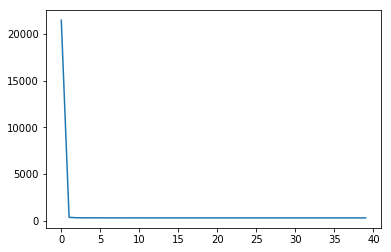

In [68]:
Ydata = Ydata.astype("float32")

print(Xdata.shape,Ydata.shape)

n_x = Xdata.shape[1]
m = Xdata.shape[1]
n_y = Ydata.shape[1]
layer_dims = [n_x,3,2,n_y]

learning_rate= tf.constant(0.1)

hl_1 = 5
hl_2 = 4
hl_3 = 3
hl_4 = 2

X = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

W1 = tf.Variable(tf.random_normal((n_x,hl_1),mean=0.5, stddev=0.1,seed=1))
b1 = tf.Variable(tf.zeros((1,hl_1)))
Z1 = tf.add(tf.matmul(X,W1),b1)
A1 = tf.nn.relu(Z1)

W2 = tf.Variable(tf.random_normal((hl_1,hl_2),mean=0.5, stddev=0.1,seed=1))
b2 = tf.Variable(tf.zeros((1,hl_2)))
Z2 = tf.add(tf.matmul(A1,W2),b2)
A2 = tf.nn.relu(Z2)

W3 = tf.Variable(tf.random_normal((hl_2,hl_3),mean=0.5, stddev=0.1,seed=1))
b3 = tf.Variable(tf.zeros((1,hl_3)))
Z3 = tf.add(tf.matmul(A2,W3),b3)
A3 = tf.nn.relu(Z3)

W4 = tf.Variable(tf.random_normal((hl_3,hl_4),mean=0.5, stddev=0.1,seed=1))
b4 = tf.Variable(tf.zeros((1,hl_4)))
Z4 = tf.add(tf.matmul(A3,W4),b4)
A4 = tf.nn.relu(Z4)

W5 = tf.Variable(tf.random_normal((hl_4,n_y),mean=0.5, stddev=0.1,seed=1))
b5 = tf.Variable(tf.zeros((1,n_y)))
ZL = tf.add(tf.matmul(A4,W5),b5)

epsilon = tf.constant(1e-6)
AL = tf.divide(1.0,tf.add(tf.add(1.0,tf.exp(-ZL)),epsilon))

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(AL,1))
accuracy = tf.multiply(tf.reduce_mean(tf.cast(correct_prediction,tf.float32)),100)

#A3 = tf.nn.sigmoid(Z3) 

logistic_cost_function = -tf.reduce_mean(tf.reduce_sum(tf.add(tf.multiply(y,tf.log(AL)),tf.multiply(tf.subtract(1.0,y),tf.log(tf.subtract(1.0,AL)))),0))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(logistic_cost_function)

init_op = tf.global_variables_initializer()

iters = 40
params = []
init_cost = 0
cost_diff_margin = 1e-6
costs = []
costs_diff = []

time_two_s = time.time()
with tf.Session() as s:
    s.run(init_op)
        
    a3,_,cost = s.run([A3,training_step,logistic_cost_function],feed_dict={X:Xdata,y:Ydata})
    init_cost = cost
    prev_cost = init_cost
    print(cost)
    
    for iterx in range(0,iters):
        _,cost = s.run([training_step,logistic_cost_function],feed_dict={X:Xdata,y:Ydata})
        print(cost)
        costs.append(cost)
        diff_cost = prev_cost - cost
        costs_diff.append(diff_cost)
        prev_cost = cost
        if diff_cost < cost_diff_margin:
            print("Convergence reached at iter:",iterx)
            break;
    params = s.run([W1,b1,W2,b2,W3,b3])
    pred = s.run(accuracy,feed_dict={X:Xdata,y:Ydata})
    print("Accuracy: ",pred,"%")
print("End loop")
time_two_e = time.time()
time_taken = time_two_e -time_two_s
print("Time taken was: ",str(np.round(time_taken)),"Seconds")

plt.plot(np.arange(0,len(costs)),costs)
plt.show()


##  Notes

Here I show which values of Z (Input of sigmoid) along with values of epsilon causes the sigmoid function to produce a 1.0, thus a Nan in the cost function

In [17]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

x=tf.placeholder(tf.float32)
p=tf.placeholder(tf.float32)
xe = tf.pow(x,p)

ep = tf.placeholder(tf.float32)
epsilon=tf.pow(10.0,-ep)

sigmoid = tf.divide(1.0,tf.add(epsilon,tf.add(1.0,tf.exp(-xe))))

sigm = np.zeros((9,9))

with tf.Session() as s:
    for i in range(1,10):
        for ei in range(1,10):
            ix=float(10)
            ip=float(i)
            r1 = s.run(sigmoid,feed_dict={x:ix,p:ip,ep:ei})
            if r1>=1:
                print("Sigmoid is 1 when Z=10^"+str(ip)+" and epsilon is e^-"+str(ei))
            sigm[i-1,ei-1]=r1
print(sigm)


Sigmoid is 1 when Z=10^2.0 and epsilon is e^-8
Sigmoid is 1 when Z=10^2.0 and epsilon is e^-9
Sigmoid is 1 when Z=10^3.0 and epsilon is e^-8
Sigmoid is 1 when Z=10^3.0 and epsilon is e^-9
Sigmoid is 1 when Z=10^4.0 and epsilon is e^-8
Sigmoid is 1 when Z=10^4.0 and epsilon is e^-9
Sigmoid is 1 when Z=10^5.0 and epsilon is e^-8
Sigmoid is 1 when Z=10^5.0 and epsilon is e^-9
Sigmoid is 1 when Z=10^6.0 and epsilon is e^-8
Sigmoid is 1 when Z=10^6.0 and epsilon is e^-9
Sigmoid is 1 when Z=10^7.0 and epsilon is e^-8
Sigmoid is 1 when Z=10^7.0 and epsilon is e^-9
Sigmoid is 1 when Z=10^8.0 and epsilon is e^-8
Sigmoid is 1 when Z=10^8.0 and epsilon is e^-9
Sigmoid is 1 when Z=10^9.0 and epsilon is e^-8
Sigmoid is 1 when Z=10^9.0 and epsilon is e^-9
[[ 0.90905333  0.99005449  0.99895561  0.99985456  0.99994457  0.99995363
   0.99995446  0.99995458  0.99995458]
 [ 0.90909088  0.99009901  0.99900097  0.99989998  0.99998999  0.99999905
   0.99999988  1.          1.        ]
 [ 0.90909088  0.99009